In [66]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import math

### Load the data

In [50]:
d = loadmat('LGN_FFdata.mat')

In [49]:
d.keys()

dict_keys(['__header__', '__version__', '__globals__', 'DTstim', 'FFspks', 'FFstim', 'FFstimR', 'FFspksR'])

In [72]:
spiks = d['FFspks'][0] # number is number of seconds from the start for that spike
stims = d['FFstim']
dt = d['DTstim'][0] # time between each stimulus
len(d['FFspksR'][0]) # data has -1s in it for each trial repeat
# Firing rate is probability of firing for a stimulus
# average rate is a rate parameter for a Poisson process

16567

In [76]:
stims # this is the intensity of the stimulus at this presentation

array([[-1.66558397],
       [ 0.125332  ],
       [ 0.28767601],
       ...,
       [-0.72446799],
       [-0.068865  ],
       [ 0.        ]])

14391


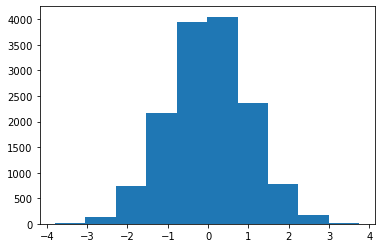

In [77]:
plt.hist(stims)
print(len(stims))

In [78]:
len(stims) * dt

array([120.00814013])

In [80]:
t = 0.02
stim_idx = math.floor(t/dt) # the stimulus trial at any time
# get multiple columns in the vector by passing in multiple indices

# we can also do some interesting matrix math to make it simpler to do


In [113]:
min(spiks), max(spiks)

(0.06999999999999318, 120.00457499999999)

### A. Calculate the average stimulus for all spike times.

In [153]:
# bin the spiks by their associated stims
def associate_spiks_to_stims(spiks, stims):
    max_spik = np.max(spiks) + dt
    return np.histogram(spiks, bins=np.arange(0, max_spik, dt))[0]

In [131]:
spiks_per_stim = associate_spiks_to_stims(spiks, stims)
len(stims), len(spiks_per_stim)

(14391, 14391)

In [154]:
# Whenever there is a spike,
# sum the stimulus values and divide by the number of spikes
stim_sum = 0.
stim_count = 0.
for stim_idx, spik in enumerate(spiks_per_stim):
    if spik > 0:
        stim_sum += spik * stims[stim_idx]
        # we want to multiply the stims by the number of spiks it elicited
        stim_count += spik
avg_stim_when_spiks = stim_sum / stim_count

In [155]:
avg_stim_when_spiks[0]
# should be 0.059 or so

0.05954608809527265

In [144]:
np.min(stims), np.max(stims)

(-3.7988569736480713, 3.747612953186035)

### B. Calculate and plot the full spike-triggered average of the neuron.

In [151]:
dt # the time steps between the stimulus presentations

array([0.00833911])

In [152]:
# moving window across the binned spikes, in 100ms (.1) bins
window_size = math.ceil(.1 / dt)

In [162]:
# slide the window over the stims
stas = []
for stim_idx in range(window_size, len(stims)):
    # get the average over the last <window_size> from the current stim
    stim_sum = 0.
    stim_count = 0.
    for stim, spik in zip(stims[stim_idx-window_size:stim_idx], spiks_per_stim[stim_idx-window_size:stim_idx]):
        if spik > 0:
            stim_sum += spik * stim
            stim_count += spik
    if stim_count > 0:
        avg_stim_when_spiks = (stim_sum / stim_count)[0]
    else:
        avg_stim_when_spiks = 0
    stas.append(avg_stim_when_spiks)

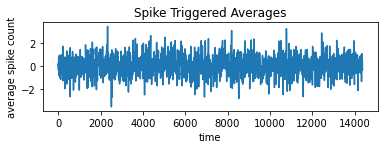

In [175]:
fig = plt.figure()
fig.subplots_adjust(top=0.8)
ax1 = fig.add_subplot(211)
ax1.set_xlabel('time')
ax1.set_ylabel('average spike count')
ax1.set_title('Spike Triggered Averages')
ax1.plot(stas)

### NOTE: this is nothing

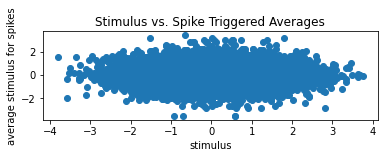

In [180]:
fig = plt.figure()
fig.subplots_adjust(top=0.8)
ax2 = fig.add_subplot(211)
ax2.set_xlabel('stimulus')
ax2.set_ylabel('average stimulus for spikes')
ax2.set_title('Stimulus vs. Spike Triggered Averages')
ax2.scatter(stims[window_size:], stas)

# Problem Set, done with matrices to make it simplerm

## 1. Temporal receptive field of a neuron

### A. Average stimulus value for all spike times

In [192]:
# bin the spiks by their associated stims
def associate_spiks_to_stims(spiks, stims):
    max_spik = np.max(spiks) + dt
    return np.histogram(spiks, bins=np.arange(0, max_spik, dt))[0]

# combine the spiks and stims by as columns
def merge_spiks_and_stims(spiks, stims):
    spiks_per_stim = associate_spiks_to_stims(spiks, stims)
    return np.column_stack([stims.flatten(), spiks_per_stim])

In [193]:
merged = merge_spiks_and_stims(spiks, stims)

In [194]:
merged

array([[-1.66558397,  0.        ],
       [ 0.125332  ,  0.        ],
       [ 0.28767601,  0.        ],
       ...,
       [-0.72446799,  0.        ],
       [-0.068865  ,  0.        ],
       [ 0.        ,  1.        ]])

In [202]:
# average stimulus for all spike times
np.sum(merged[:,0] * merged[:,1]) / np.sum(merged[:,1])

0.05954608809527265

### B. STA of the neuron

In [209]:
# moving window across the binned spikes, in 100ms (.1) bins
w = math.ceil(.1 / dt)

In [210]:
sta = [np.sum(merged[i-w:i,0] * merged[i-w:i,1]) / np.sum(merged[i-w:i,1]) for i in range(w, len(stims))]

/var/folders/rc/lxb7w_kn1gd1gppq2y1hq2tm0000gn/T/ipykernel_6060/1333173150.py:1: RuntimeWarning: invalid value encountered in double_scalars
  sta = [np.sum(merged[i-w:i,0] * merged[i-w:i,1]) / np.sum(merged[i-w:i,1]) for i in range(w, len(stims))]


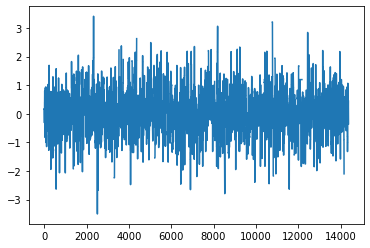

In [207]:
plt.plot(sta)

## 2. Calculating the spiking nonlinearity